In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '5'
os.environ['HOME'] = '/data25/wuqin'
import clip
import torch
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

from matplotlib.font_manager import fontManager, FontProperties
font_path = os.path.expanduser('~/SimHei.ttf')
fontManager.addfont(font_path)

font_prop = FontProperties(fname=font_path)
actual_font_name = font_prop.get_name()

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = [actual_font_name]  # 使用获取到的实际字体名称
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

print(f"当前使用的字体: {plt.rcParams['font.sans-serif']}")

当前使用的字体: ['SimHei']


In [15]:
# 导入模型
model_name = "CS-ViT-L/14"
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load(model_name, device=device)
model = model.eval()
is_meta_clip = 'Meta' in model_name
prompt_templates = ['{}'] if is_meta_clip else None

In [16]:
# MetaCLIP
def get_tokenizer(tokenizer: str):
    from transformers import AutoTokenizer
    os.environ["TOKENIZERS_PARALLELISM"] = "false"
    tokenizer = AutoTokenizer.from_pretrained(tokenizer, use_fast=True)

    def tokenize_fn(txt_list):
        input_ids = tokenizer(txt_list, return_tensors='pt', padding='max_length', truncation=True, max_length=77)['input_ids']
        return input_ids

    return tokenize_fn
if is_meta_clip:
    tokenize = get_tokenizer("/data25/wuqin/.cache/huggingface/hub/models--facebook--xlm-v-base/snapshots/68c75dd7733d2640b3a98114e3e94196dc543fe1")
else:
    tokenize = clip.tokenize

In [18]:
pil_img = Image.open("examples/hall_4f_25/images/low1_1.jpg")
cv2_img = cv2.cvtColor(np.array(pil_img), cv2.COLOR_RGB2BGR)
image = preprocess(pil_img).unsqueeze(0).to(device)
print(f'raw image shape: {image.shape}')
print(f'preprocessed image shape: {cv2_img.shape}')

raw image shape: torch.Size([1, 3, 224, 224])
preprocessed image shape: (412, 550, 3)


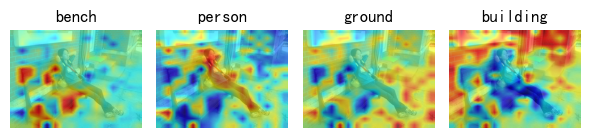

In [ ]:
# 多目标查询
multi_texts = ['bench', 'person', 'ground', 'building']
# multi_texts = ['椅子', '人', '地面', '建筑']
with torch.no_grad():
    # CLIP architecture surgery acts on the image encoder
    image_features = model.encode_image(image)
    image_features = image_features / image_features.norm(dim=-1, keepdim=True)

    # Prompt ensemble for text features with normalization
    text_features = clip.encode_text_with_prompt_ensemble(model, multi_texts, device, tokenize=tokenize, prompt_templates=prompt_templates)

    # Apply feature surgery
    similarity = clip.clip_feature_surgery(image_features, text_features)
    similarity_map = clip.get_similarity_map(similarity[:, 1:, :], cv2_img.shape[:2])

    # Draw similarity map
    fig, axes = plt.subplots(nrows=similarity_map.shape[0], ncols=similarity_map.shape[-1], figsize=(6, 4*similarity_map.shape[-1]))
    for b in range(similarity_map.shape[0]):
        for n in range(similarity_map.shape[-1]):
            vis = (similarity_map[b, :, :, n].cpu().numpy() * 255).astype('uint8')
            vis = cv2.applyColorMap(vis, cv2.COLORMAP_JET)
            vis = cv2_img * 0.4 + vis * 0.6
            vis = cv2.cvtColor(vis.astype('uint8'), cv2.COLOR_BGR2RGB)
            axes[n].imshow(vis)
            axes[n].set_title(multi_texts[n])
            axes[n].axis('off')
    plt.tight_layout()
    plt.show()

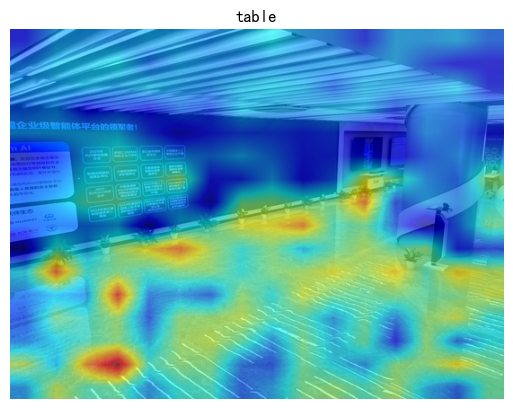

In [24]:
# 单目标查询
single_text = "table"
with torch.no_grad():
    # CLIP architecture surgery acts on the image encoder
    image_features = model.encode_image(image)
    image_features = image_features / image_features.norm(dim=-1, keepdim=True)

    # Prompt ensemble for text features with normalization
    text_features = clip.encode_text_with_prompt_ensemble(model, [single_text], device, tokenize=tokenize, prompt_templates=prompt_templates)
    # Extract redundant features from an empty string
    redundant_features = clip.encode_text_with_prompt_ensemble(model, [""], device, tokenize=tokenize, prompt_templates=prompt_templates)

    # Apply feature surgery for single text
    similarity = clip.clip_feature_surgery(image_features, text_features, redundant_features)
    similarity_map = clip.get_similarity_map(similarity[:, 1:, :], cv2_img.shape[:2])

    # Draw similarity map
    for b in range(similarity_map.shape[0]):
        for n in range(similarity_map.shape[-1]):
            vis = (similarity_map[b, :, :, n].cpu().numpy() * 255).astype('uint8')
            vis = cv2.applyColorMap(vis, cv2.COLORMAP_JET)
            vis = cv2_img * 0.4 + vis * 0.6
            vis = cv2.cvtColor(vis.astype('uint8'), cv2.COLOR_BGR2RGB)
            plt.imshow(vis)
            plt.title(single_text)
            plt.axis('off')
            plt.show()